In [9]:
# Quelle: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
# pip install torchtext
# pip install spacy
# python -m spacy download de
# pip install torch


import pandas as pd

df=pd.read_csv("news.csv")
df.head()


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [10]:
# uns interessiert erstmal nur title und label
df = df[["title", "text", "label"]]
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [11]:
# convert label to numeric
df["label"] = df["label"].astype("category").cat.codes
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [12]:
df["input"]=df["title"]

<Axes: >

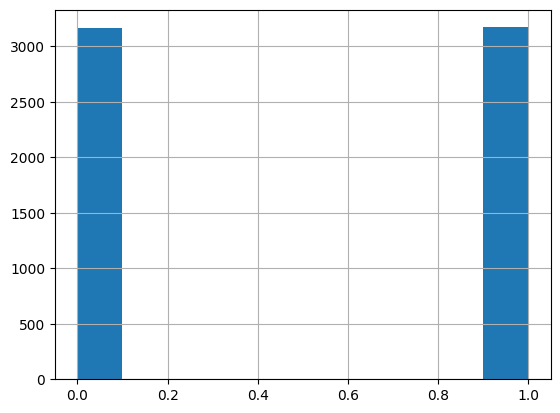

In [13]:
df.label.hist()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   int8  
 3   input   6335 non-null   object
dtypes: int8(1), object(3)
memory usage: 154.8+ KB


In [15]:
from torchtext.data.utils import get_tokenizer


In [16]:
#python3 -m spacy download en_core_web_sm
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')




In [17]:
# Vokabular erstellen
def build_vocab(texts, vocab_size):
    word_counts = {}
    for text in texts:
        tokens = tokenizer(text)
        for token in tokens:
            if token in word_counts:
                word_counts[token] += 1
            else:
                word_counts[token] = 1
    sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_vocab = sorted_vocab[:vocab_size-1]
    word_to_idx = {word: idx+1 for idx, (word, _) in enumerate(sorted_vocab)}
    word_to_idx['<unk>'] = 0
    return word_to_idx

# Texte in Sequenzen von Wortindizes umwandeln
def text_to_indices(text, word_to_idx):
    tokens = tokenizer(text)
    indices = [word_to_idx[token] if token in word_to_idx else 0 for token in tokens]
    return indices

vocab_size = 10000

# Erstellung des Vokabulars
texts = df['input'].tolist()
word_to_idx = build_vocab(texts, vocab_size)

In [18]:

text_to_indices("Hillary is fame", word_to_idx)

[16, 20, 0]

In [19]:
def text_pipeline(x):                           # die benutzen wir später um Text in Vektoren zu übersetzen
    return text_to_indices(x, word_to_idx)
    
label_pipeline = lambda x: int(x)         # (andere Schreibweise) die ratings liegen als Text vor und gehen von 1 bis 5. Daher -1

In [20]:
text_pipeline('This year will be great!') 


[68, 274, 129, 60, 1452, 40]

In [21]:
from torch.utils.data import DataLoader
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    '''
    Extrahiert aus einer Batch von Text die Labels und die Texte und übersetzt diese in Vektoren(Zahlen-Arrays) mittels text_pipeline und label_pipeline
    '''
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

# check if collate_batch works
collate_batch([("Das neue IPhone ist wirklich toll!!", "5"), ("FritzBox 7830 ist schon ganz nett, aber geht besser", "3")])

(tensor([5, 3]),
 tensor([ 0,  0,  0,  0,  0,  0, 40, 40,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0]),
 tensor([0, 8]))

In [22]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [23]:
num_class = df["label"].nunique()
emsize = 64
print(num_class, vocab_size, emsize)

2 10000 64


In [24]:
import time

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [25]:
from torch.utils.data.dataset import random_split

train_dataset=df[['input', 'label']].values;

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

-----------------------------------------------------------
| end of epoch   1 | time:  1.37s | train accuracy    0.692 | valid accuracy    0.703 | lr: 5.00
-----------------------------------------------------------
| end of epoch   2 | time:  0.76s | train accuracy    0.655 | valid accuracy    0.631 | lr: 5.00
-----------------------------------------------------------
| end of epoch   3 | time:  0.86s | train accuracy    0.661 | valid accuracy    0.618 | lr: 5.00
-----------------------------------------------------------
| end of epoch   4 | time:  0.77s | train accuracy    0.918 | valid accuracy    0.855 | lr: 3.50
-----------------------------------------------------------
| end of epoch   5 | time:  0.70s | train accuracy    0.718 | valid accuracy    0.675 | lr: 3.50
-----------------------------------------------------------
| end of epoch   6 | time:  0.96s | train accuracy    0.939 | valid accuracy    0.852 | lr: 3.50
----------------------------------------------------------

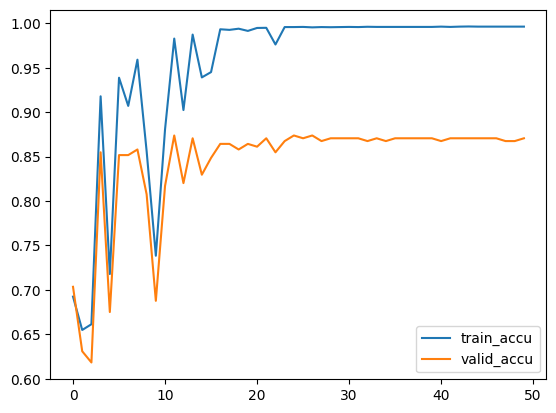

In [26]:
# Hyperparameters
EPOCHS = 50 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,collate_fn=collate_batch)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3.0, gamma=0.7)   # every 3 epochs, LR is multiplied by 0.7
total_accu = None

train_accus=[]
valid_accus=[]


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    model.train()
    total_acc, total_count = 0, 0

    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = loss_func(predicted_label, label)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

    accu_train = evaluate(model, train_dataloader)
    accu_valid = evaluate(model, valid_dataloader)
    train_accus.append(accu_train)
    valid_accus.append(accu_valid)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train accuracy {:8.3f} | valid accuracy {:8.3f} | lr: {:1.2f}'.format(
                                epoch,
                                time.time() - epoch_start_time,
                                accu_train, 
                                accu_valid, 
                                scheduler.get_last_lr()[0]))

    scheduler.step() # learning rate scheduler after each epoch



import matplotlib.pyplot as plt
plt.plot(train_accus, label='train_accu')
plt.plot(valid_accus, label='valid_accu')
plt.legend()
plt.show()

In [27]:
# how much valid accuracy do we get in a new untrained model?
new_model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
evaluate(new_model, valid_dataloader)


0.47003154574132494